# Potential Energy Surface Derived Property Predictions with MLIPs

Here we will use a relatively new package called `MatCalc` (same developers as `Pymatgen`) that can predict materials properties that can be derived from the potential energy surface (PES) facilitated by the MLIPs.

In [1]:
%%capture
!uv pip install matcalc
!uv pip install mp-api>=0.45.12
!uv pip install mace-torch>=0.3.12
!uv pip install nglview

## Property Predictions with `MatCalc`

We will use the MACE MLIP here.

In [2]:
from mace.calculators import mace_mp
from matcalc import EOSCalc
from ase.build import bulk
import numpy as np

# Load small, medium, or large MACE model; autodetect device; use float64 precision
calc = mace_mp(model="small", device="", default_dtype="float64")

structure = bulk("Al", "fcc", a=4.05)

# MatCalc equation of state
eosc = EOSCalc(calc)
eos_props = eosc.calc(structure)
print(eos_props.keys())

/usr/local/lib/python3.12/dist-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))


cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.


/usr/local/lib/python3.12/dist-packages/matcalc/utils.py:54: UserWarning: Unable to get pre-trained MatGL universal calculators.
  warnings.warn("Unable to get pre-trained MatGL universal calculators.", stacklevel=1)


Cached MACE model to /root/.cache/mace/20231210mace128L0_energy_epoch249model
Using Materials Project MACE for MACECalculator with /root/.cache/mace/20231210mace128L0_energy_epoch249model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.
Using head Default out of ['Default']


/usr/local/lib/python3.12/dist-packages/mace/calculators/mace.py:197: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


dict_keys(['final_structure', 'energy', 'forces', 'stress', 'a', 'b', 'c', 'alpha', 'beta', 'gamma', 'volume', 'eos', 'bulk_modulus_bm', 'r2_score_bm'])


In [3]:
print(eos_props["eos"])  # Full EOS data (volumes, energies)
# convert bulk modulus from GPa to eV/Å^3
bm_gpa = eos_props["bulk_modulus_bm"]
eV_per_A3_per_GPa = 160.2176621
bm_ev_per_A3 = bm_gpa / eV_per_A3_per_GPa
print(f"Bulk modulus: {bm_gpa:.6f} GPa = {bm_ev_per_A3:.6f} eV/Å^3")

from pymatgen.analysis.eos import BirchMurnaghan
bm = BirchMurnaghan(eos_props["eos"]["volumes"], eos_props["eos"]["energies"])
bm.fit()  # Fitted EOS parameters
v0 = bm.v0  # Equilibrium volume from fit
print(f"{v0=:.3f} Å³")
a0 = (bm.v0 * (2 ** 0.5)) ** (1 / 3)  # Lattice parameter from fitted equilibrium volume
print(f"{a0=:.3f} Å")
e0 = bm.e0  # Minimum energy from fit
print(f"{e0=:.3f} eV/atom")  # Primitive cell has 1 atom

{'volumes': [12.106890281250001, 12.932085293999998, 13.793949735749996, 14.693280768, 15.630875552249998, 16.607531249999997, 17.624045022750003, 18.681214031999996, 19.77983543924999, 20.920706406000008, 22.104624093750015], 'energies': [-3.212204212570346, -3.402276767667993, -3.541627499727828, -3.6381978864977675, -3.692323832221435, -3.7095693805526193, -3.6967828080136322, -3.659715834652139, -3.602970636789058, -3.530548770733119, -3.445994805917882]}
Bulk modulus: 76.117024 GPa = 0.475085 eV/Å^3
v0=16.709 Å³
a0=2.870 Å
e0=-3.708 eV/atom


Compare this to the DFT ground-truth values from the Materials Project [link](https://next-gen.materialsproject.org/materials/mp-134):

a0 = 2.86 A<br>
V0 = 16.51335 A^3<br>
B_0 = 0.4611 eV/A^3

Let us plot the equation of state (energies vs. volumes).

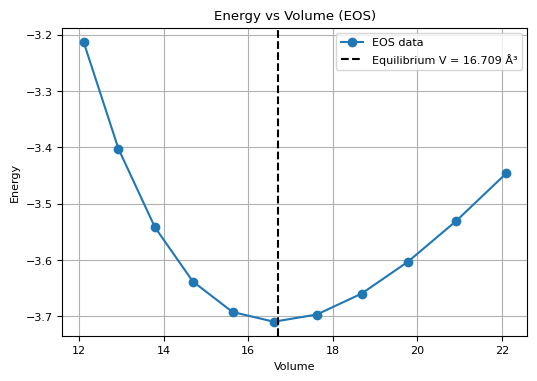

In [4]:
import matplotlib.pyplot as plt

eos = eos_props["eos"]
volumes = np.array(eos["volumes"])
energies = np.array(eos["energies"])

plt.figure(figsize=(6, 4))
plt.plot(volumes, energies, "o-", markersize=6, label="EOS data")
plt.axvline(v0, color="k", linestyle="--", label=f"Equilibrium V = {v0:.3f} Å³")
plt.xlabel("Volume")
plt.ylabel("Energy")
plt.title("Energy vs Volume (EOS)")
plt.grid(True)
plt.legend()
plt.show()

There are more properties that can be derived from the PES. This includes phonon-related properties, formation energies, and elasticity tensors (see below), among others.

In [5]:
from matcalc import ElasticityCalc
# MatCalc elasticity
ec = ElasticityCalc(
    calc,
    relax_structure=False,
    relax_deformed_structures=False,
    use_equilibrium=True,
    fmax=0.05,
)
props = ec.calc(structure)
# Raw tensor as returned by MatCalc (3x3x3x3):
print(props.keys())

dict_keys(['final_structure', 'elastic_tensor', 'shear_modulus_vrh', 'bulk_modulus_vrh', 'youngs_modulus', 'residuals_sum', 'structure'])


In [6]:
C_raw = np.array(props["elastic_tensor"], dtype=float)
print("Elasticity tensor (Voigt notation):", C_raw, sep="\n")
print(f"Shear modulus G (Voigt–Reuss–Hill average): {props['shear_modulus_vrh']:.3f} eV/Å³")
print(f"Bulk modulus B (Voigt–Reuss–Hill average): {props['bulk_modulus_vrh']:.3f} eV/Å³")
print(f"Young's modulus E: {props['youngs_modulus']:.1f} eV/Å³")

Elasticity tensor (Voigt notation):
[[[[0.65343019 0.         0.        ]
   [0.         0.42550888 0.        ]
   [0.         0.         0.42550888]]

  [[0.         0.166869   0.        ]
   [0.166869   0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.166869  ]
   [0.         0.         0.        ]
   [0.166869   0.         0.        ]]]


 [[[0.         0.166869   0.        ]
   [0.166869   0.         0.        ]
   [0.         0.         0.        ]]

  [[0.42550888 0.         0.        ]
   [0.         0.65343019 0.        ]
   [0.         0.         0.42550888]]

  [[0.         0.         0.        ]
   [0.         0.         0.166869  ]
   [0.         0.166869   0.        ]]]


 [[[0.         0.         0.166869  ]
   [0.         0.         0.        ]
   [0.166869   0.         0.        ]]

  [[0.         0.         0.        ]
   [0.         0.         0.166869  ]
   [0.         0.166869   0.        ]]

  [[0.42550888 0.         0.    

## Exercise 17.1

Pick a different (more complex) material from the Materials Project and compare the bulk modulus values.

Please, fill in the mpid and its chemical composition and the results into [this Google Sheet](https://docs.google.com/spreadsheets/d/1xyZJE2nErCL4HIT6vFfMY9oFyOXoBfHyBRVZDDbI3cA/).

### Specify your API Key

In [9]:
API_KEY = "9ODrRnEr99D0fuMJVxgZlrwauUWOoe3m"  # Replace with your Materials Project API key

### Query MP and Compare Bulk Modulus Predictions

In [10]:
from mace.calculators import mace_mp
from matcalc import EOSCalc
from mp_api.client import MPRester

mpid = "mp-7777"  # Replace with your chosen material ID

with MPRester(API_KEY) as mpr:
    docs = mpr.materials.summary.search(material_ids=[mpid], fields=["structure", "bulk_modulus"])
    structure_exercise = docs[0].structure  # type: ignore
    bulk_modulus_mp = docs[0].bulk_modulus  # type: ignore
    # structure_exercise = mpr.get_structure_by_material_id("mp-149")

# Load small, medium, or large MACE model; autodetect device; use float64 precision
calc = mace_mp(model="small", device="", default_dtype="float64")

# MatCalc equation of state
eosc_exercise = EOSCalc(calc)
eos_props_exercise = eosc_exercise.calc(structure_exercise)  # type: ignore
bm_gpa_exercise = eos_props_exercise["bulk_modulus_bm"]
print(f"Bulk modulus (MLIP-calculated): {bm_gpa_exercise:.6f} GPa")
print(f"Bulk modulus (Materials Project): {bulk_modulus_mp} GPa")

Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Using Materials Project MACE for MACECalculator with /root/.cache/mace/20231210mace128L0_energy_epoch249model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.
Using head Default out of ['Default']


/usr/local/lib/python3.12/dist-packages/mace/calculators/mace.py:197: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Bulk modulus (MLIP-calculated): 46.266175 GPa
Bulk modulus (Materials Project): {'voigt': 49.176, 'reuss': 49.166, 'vrh': 49.171} GPa


## MD Simulation Utilizing MLIPs
Let us now run an MD simulation with near-ab initio accuracy of a molecule adsorbed on a surface.

In [11]:
from ase.build import fcc111, add_adsorbate, molecule
from ase.constraints import FixAtoms
from ase.visualize import view

# build a Cu(111) slab (3x3 surface cell, 4 layers) with vacuum
slab = fcc111('Cu', size=(4, 4, 5), vacuum=12.0, orthogonal=True)
slab.calc = calc  # attach the MACE calculator
slab_energy = slab.get_potential_energy()

# create a CO molecule
co = molecule('CO')
co_iso = co.copy()
co_iso.center(vacuum=12.0)
co_iso.set_pbc([False, False, False])
co_iso.calc = calc
co_energy = co_iso.get_potential_energy()

# Add molecule to the surface
add_adsorbate(slab, co, height=3.0, position="ontop")

# optionally constrain the bottom layers to mimic a bulk-like slab
z = slab.get_positions()[:, 2]
threshold = z.max() - 3.0  # atoms more than 3.0 Å below the top surface are fixed
mask = z < threshold
slab.set_constraint(FixAtoms(mask=mask))

print(slab)
total_energy_slab_adsorbed = slab.get_potential_energy()
print(f"Adsorption energy = {total_energy_slab_adsorbed - slab_energy - co_energy:.3f} eV")

view(slab, viewer='ngl')

Atoms(symbols='CCu80O', pbc=[True, True, False], cell=[10.210621920333747, 8.842657971447272, 32.336937887098195], tags=..., constraint=FixAtoms(indices=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]), calculator=MACECalculator(...))
Adsorption energy = -0.798 eV


Now the NVT MD simulation with the MACE calculator.

In [12]:
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.nvtberendsen import NVTBerendsen
from ase.io.trajectory import Trajectory
from ase import units
from ase.io import write

# Initialize velocities to correspond to 300 K
MaxwellBoltzmannDistribution(slab, temperature_K=300)

# NVT dynamics for equilibration
dyn = NVTBerendsen(
    slab,
    timestep=2.0 * units.fs,
    temperature_K=300,
    taut=100.0 * units.fs
)

# Run Simulation and log data
def print_status(a=slab):
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    temp = ekin / (1.5 * units.kB)
    print(f"Step {dyn.nsteps:>4}: T = {temp:5.1f} K | Epot = {epot:6.3f} eV/atom | Etot = {(epot+ekin):6.3f} eV/atom")

traj = Trajectory('md.traj', 'w', slab)

dyn.attach(print_status, interval=10)
dyn.attach(traj.write, interval=10)

dyn.run(200)  # Run for 200 steps (≈ 0.4 ps)

Step    0: T =  40.7 K | Epot = -3.994 eV/atom | Etot = -3.989 eV/atom
Step   10: T =  37.7 K | Epot = -3.993 eV/atom | Etot = -3.989 eV/atom
Step   20: T =  27.6 K | Epot = -3.991 eV/atom | Etot = -3.988 eV/atom
Step   30: T =  27.2 K | Epot = -3.990 eV/atom | Etot = -3.987 eV/atom
Step   40: T =  43.9 K | Epot = -3.992 eV/atom | Etot = -3.986 eV/atom
Step   50: T =  59.5 K | Epot = -3.993 eV/atom | Etot = -3.986 eV/atom
Step   60: T =  70.8 K | Epot = -3.995 eV/atom | Etot = -3.986 eV/atom
Step   70: T =  70.3 K | Epot = -3.995 eV/atom | Etot = -3.986 eV/atom
Step   80: T =  56.7 K | Epot = -3.993 eV/atom | Etot = -3.986 eV/atom
Step   90: T =  51.3 K | Epot = -3.993 eV/atom | Etot = -3.986 eV/atom
Step  100: T =  45.8 K | Epot = -3.991 eV/atom | Etot = -3.985 eV/atom
Step  110: T =  53.5 K | Epot = -3.992 eV/atom | Etot = -3.985 eV/atom
Step  120: T =  42.4 K | Epot = -3.990 eV/atom | Etot = -3.985 eV/atom
Step  130: T =  54.0 K | Epot = -3.991 eV/atom | Etot = -3.984 eV/atom
Step  

True

In [13]:
from ase.io import read
from ase.visualize import view

traj_visualize = read("md.traj", index=':')
print(f"Loaded {len(traj_visualize)} frames from 'md.traj'")
view(traj_visualize, viewer="ngl")

Loaded 21 frames from 'md.traj'


In [16]:
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.nvtberendsen import NVTBerendsen
from ase.io.trajectory import Trajectory
from ase import units
from ase.io import write

# Initialize velocities to correspond to 300 K
MaxwellBoltzmannDistribution(slab, temperature_K=300)

# NVT dynamics for equilibration
dyn = NVTBerendsen(
    slab,
    timestep=2.0 * units.fs,
    temperature_K=300,
    taut=75.0 * units.fs
)

# Run Simulation and log data
def print_status(a=slab):
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    temp = ekin / (1.5 * units.kB)
    print(f"Step {dyn.nsteps:>4}: T = {temp:5.1f} K | Epot = {epot:6.3f} eV/atom | Etot = {(epot+ekin):6.3f} eV/atom")

traj = Trajectory('md.traj', 'w', slab)

dyn.attach(print_status, interval=10)
dyn.attach(traj.write, interval=10)

dyn.run(500)  # Run for 500 steps (≈ 1 ps)

Step    0: T =  58.8 K | Epot = -3.991 eV/atom | Etot = -3.983 eV/atom
Step   10: T =  60.7 K | Epot = -3.991 eV/atom | Etot = -3.984 eV/atom
Step   20: T =  60.6 K | Epot = -3.991 eV/atom | Etot = -3.984 eV/atom
Step   30: T =  56.8 K | Epot = -3.991 eV/atom | Etot = -3.983 eV/atom
Step   40: T =  58.7 K | Epot = -3.991 eV/atom | Etot = -3.983 eV/atom
Step   50: T =  71.2 K | Epot = -3.992 eV/atom | Etot = -3.983 eV/atom
Step   60: T =  81.9 K | Epot = -3.994 eV/atom | Etot = -3.983 eV/atom
Step   70: T =  71.7 K | Epot = -3.993 eV/atom | Etot = -3.984 eV/atom
Step   80: T =  63.9 K | Epot = -3.992 eV/atom | Etot = -3.984 eV/atom
Step   90: T =  61.3 K | Epot = -3.992 eV/atom | Etot = -3.984 eV/atom
Step  100: T =  59.9 K | Epot = -3.991 eV/atom | Etot = -3.983 eV/atom
Step  110: T =  56.6 K | Epot = -3.991 eV/atom | Etot = -3.983 eV/atom
Step  120: T =  48.7 K | Epot = -3.989 eV/atom | Etot = -3.983 eV/atom
Step  130: T =  61.4 K | Epot = -3.990 eV/atom | Etot = -3.982 eV/atom
Step  

True

In [17]:
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.nvtberendsen import NVTBerendsen
from ase.io.trajectory import Trajectory
from ase import units
from ase.io import write

# Initialize velocities to correspond to 300 K
MaxwellBoltzmannDistribution(slab, temperature_K=300)

# NVT dynamics for equilibration
dyn = NVTBerendsen(
    slab,
    timestep=2.0 * units.fs,
    temperature_K=300,
    taut=50.0 * units.fs
)

# Run Simulation and log data
def print_status(a=slab):
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    temp = ekin / (1.5 * units.kB)
    print(f"Step {dyn.nsteps:>4}: T = {temp:5.1f} K | Epot = {epot:6.3f} eV/atom | Etot = {(epot+ekin):6.3f} eV/atom")

traj = Trajectory('md.traj', 'w', slab)

dyn.attach(print_status, interval=10)
dyn.attach(traj.write, interval=10)

dyn.run(500)  # Run for 500 steps (≈ 1 ps)

Step    0: T =  63.5 K | Epot = -3.992 eV/atom | Etot = -3.984 eV/atom
Step   10: T =  66.5 K | Epot = -3.993 eV/atom | Etot = -3.984 eV/atom
Step   20: T =  70.5 K | Epot = -3.993 eV/atom | Etot = -3.984 eV/atom
Step   30: T =  70.7 K | Epot = -3.994 eV/atom | Etot = -3.985 eV/atom
Step   40: T =  65.5 K | Epot = -3.993 eV/atom | Etot = -3.985 eV/atom
Step   50: T =  52.1 K | Epot = -3.991 eV/atom | Etot = -3.984 eV/atom
Step   60: T =  47.7 K | Epot = -3.990 eV/atom | Etot = -3.984 eV/atom
Step   70: T =  57.0 K | Epot = -3.990 eV/atom | Etot = -3.983 eV/atom
Step   80: T =  68.9 K | Epot = -3.992 eV/atom | Etot = -3.983 eV/atom
Step   90: T =  78.9 K | Epot = -3.993 eV/atom | Etot = -3.983 eV/atom
Step  100: T =  71.9 K | Epot = -3.993 eV/atom | Etot = -3.984 eV/atom
Step  110: T =  60.2 K | Epot = -3.992 eV/atom | Etot = -3.984 eV/atom
Step  120: T =  61.1 K | Epot = -3.991 eV/atom | Etot = -3.984 eV/atom
Step  130: T =  64.9 K | Epot = -3.992 eV/atom | Etot = -3.984 eV/atom
Step  

True

In [18]:
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.nvtberendsen import NVTBerendsen
from ase.io.trajectory import Trajectory
from ase import units
from ase.io import write

# Initialize velocities to correspond to 300 K
MaxwellBoltzmannDistribution(slab, temperature_K=300)

# NVT dynamics for equilibration
dyn = NVTBerendsen(
    slab,
    timestep=2.0 * units.fs,
    temperature_K=300,
    taut=25.0 * units.fs
)

# Run Simulation and log data
def print_status(a=slab):
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    temp = ekin / (1.5 * units.kB)
    print(f"Step {dyn.nsteps:>4}: T = {temp:5.1f} K | Epot = {epot:6.3f} eV/atom | Etot = {(epot+ekin):6.3f} eV/atom")

traj = Trajectory('md.traj', 'w', slab)

dyn.attach(print_status, interval=10)
dyn.attach(traj.write, interval=10)

dyn.run(500)  # Run for 500 steps (≈ 1 ps)

Step    0: T =  62.6 K | Epot = -3.992 eV/atom | Etot = -3.984 eV/atom
Step   10: T =  59.2 K | Epot = -3.991 eV/atom | Etot = -3.983 eV/atom
Step   20: T =  63.6 K | Epot = -3.990 eV/atom | Etot = -3.982 eV/atom
Step   30: T =  74.1 K | Epot = -3.992 eV/atom | Etot = -3.982 eV/atom
Step   40: T =  67.8 K | Epot = -3.992 eV/atom | Etot = -3.983 eV/atom
Step   50: T =  68.0 K | Epot = -3.992 eV/atom | Etot = -3.983 eV/atom
Step   60: T =  68.0 K | Epot = -3.992 eV/atom | Etot = -3.984 eV/atom
Step   70: T =  62.4 K | Epot = -3.992 eV/atom | Etot = -3.984 eV/atom
Step   80: T =  62.5 K | Epot = -3.992 eV/atom | Etot = -3.984 eV/atom
Step   90: T =  56.2 K | Epot = -3.990 eV/atom | Etot = -3.983 eV/atom
Step  100: T =  62.4 K | Epot = -3.990 eV/atom | Etot = -3.982 eV/atom
Step  110: T =  72.9 K | Epot = -3.992 eV/atom | Etot = -3.982 eV/atom
Step  120: T =  70.6 K | Epot = -3.992 eV/atom | Etot = -3.983 eV/atom
Step  130: T =  69.2 K | Epot = -3.992 eV/atom | Etot = -3.983 eV/atom
Step  

True

## Exercise 17.2

Redo this simulation but for a different transition metal surface and a different molecule that is adsorbed.

Again, please, fill in the transition metal, surface, and molecule and the adsorption energy into [this Google Sheet](https://docs.google.com/spreadsheets/d/1xyZJE2nErCL4HIT6vFfMY9oFyOXoBfHyBRVZDDbI3cA/).